In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('boxoffice.csv',
                 encoding='latin-1')
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,The Avengers,6026491,1274885664,Warner Bros.,163620146,253,174687337,R,Animation,16
1,Titanic,169411543,1132871091,Disney,85549990,122,103948486,G,Action,103
2,Jurassic Park,107836098,583329845,Sony,55681429,3826,122104991,NC-17,Horror,89
3,Avatar,51433697,1225323391,Disney,109775324,3868,46431596,G,Horror,85
4,The Lion King,142791649,604140729,Warner Bros.,59476800,2934,203513696,R,Comedy,158


In [4]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   int64 
 2   world_revenue     2694 non-null   int64 
 3   distributor       2694 non-null   object
 4   opening_revenue   2694 non-null   int64 
 5   opening_theaters  2694 non-null   int64 
 6   budget            2694 non-null   int64 
 7   MPAA              2694 non-null   object
 8   genres            2694 non-null   object
 9   release_days      2694 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 210.6+ KB


In [5]:
to_remove = ['world_revenue', 'opening_revenue']
df.drop(to_remove, axis=1, inplace=True)

In [6]:
df.isnull().sum() * 100 / df.shape[0]

,0
title,0.0
domestic_revenue,0.0
distributor,0.0
opening_theaters,0.0
budget,0.0
MPAA,0.0
genres,0.0
release_days,0.0


In [7]:
df.drop('budget', axis=1, inplace=True)

for col in ['MPAA', 'genres']:
    df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(inplace=True)

df.isnull().sum().sum()

np.int64(0)

In [8]:
df['domestic_revenue'] = df['domestic_revenue'].astype(str).str[1:]

for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
    df[col] = df[col].astype(str).str.replace(',', '')

    temp = (~df[col].isnull())
    df[temp][col] = df[temp][col].convert_dtypes(float)

    df[col] = pd.to_numeric(df[col], errors='coerce')

In [9]:
df['domestic_revenue'] = df['domestic_revenue'].astype(str).str[1:]

for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
    df[col] = df[col].astype(str).str.replace(',', '')

    temp = (~df[col].isnull())
    df[temp][col] = df[temp][col].convert_dtypes(float)

    df[col] = pd.to_numeric(df[col], errors='coerce')

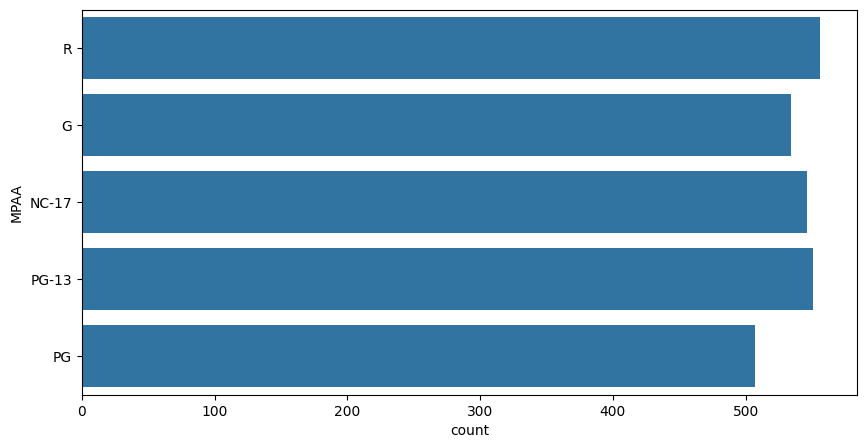

In [10]:
plt.figure(figsize=(10, 5))
sb.countplot(df['MPAA'])
plt.show()

In [11]:
df.groupby('MPAA')['domestic_revenue'].mean()

,domestic_revenue
MPAA,
G,3.320203e+06
NC-17,3.095755e+06
PG,3.388151e+06
PG-13,3.070569e+06
R,3.353680e+06


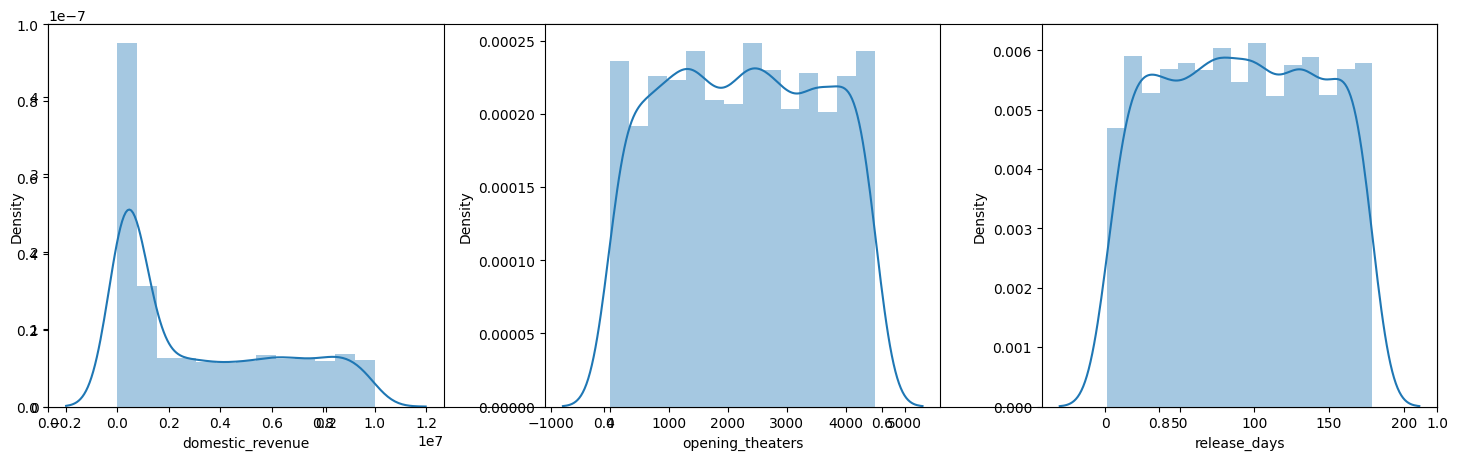

In [12]:
plt.subplots(figsize=(15, 5))

features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

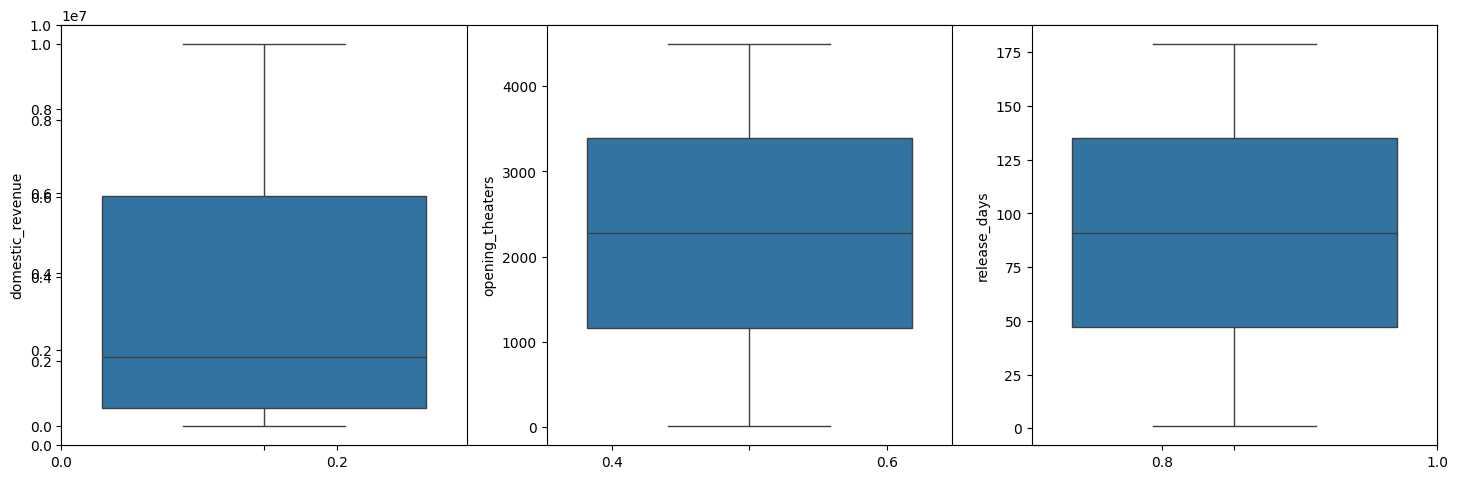

In [13]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.boxplot(df[col])
plt.tight_layout()
plt.show()

In [14]:
for col in features:
  df[col] = df[col].apply(lambda x: np.log10(x))

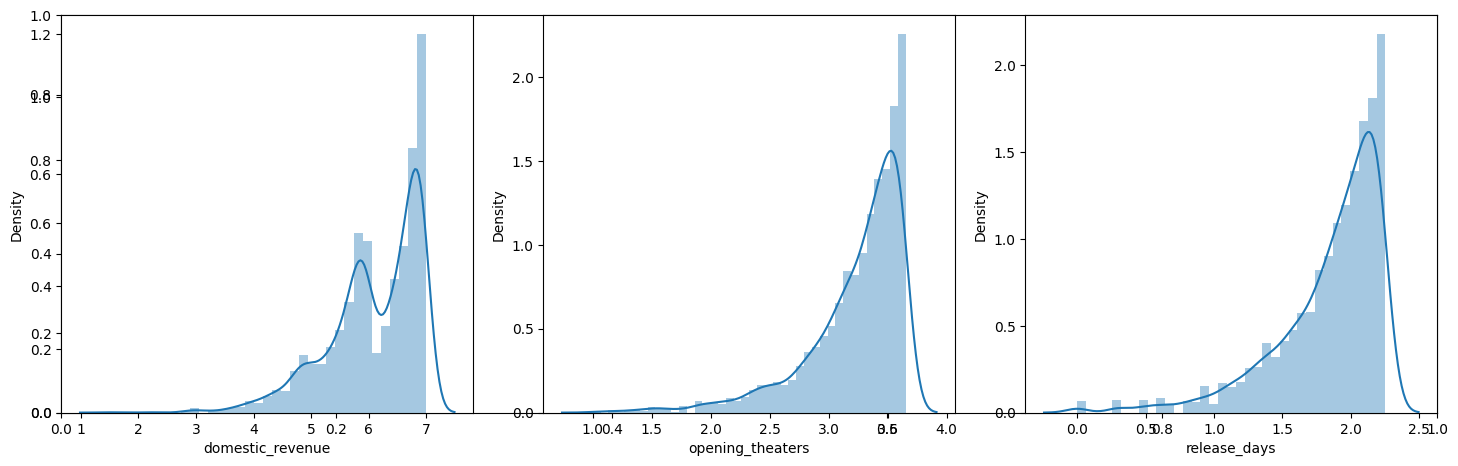

In [15]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])
features = vectorizer.transform(df['genres']).toarray()

genres = vectorizer.get_feature_names_out()
for i, name in enumerate(genres):
	df[name] = features[:, i]

df.drop('genres', axis=1, inplace=True)

In [17]:
removed = 0

if 'action' in df.columns and 'western' in df.columns:
    for col in df.loc[:, 'action':'western'].columns:

        if (df[col] == 0).mean() > 0.95:
            removed += 1
            df.drop(col, axis=1, inplace=True)

print(removed)
print(df.shape)

0
(2694, 12)


<Figure size 800x800 with 0 Axes>

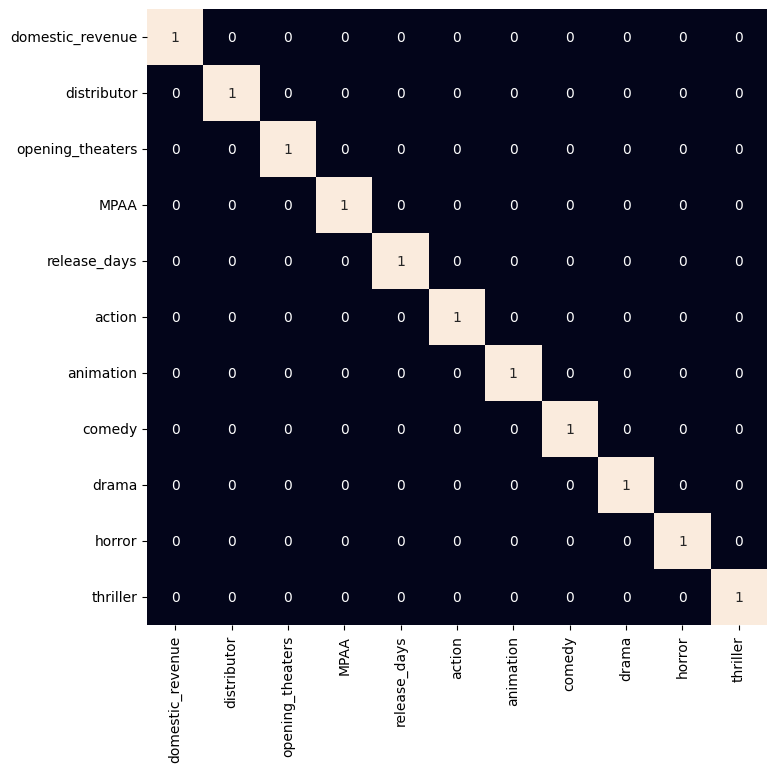

((2424, 10), (270, 10))

In [18]:
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    plt.figure(figsize=(8, 8))
sb.heatmap(df.select_dtypes(include=np.number).corr() > 0.8,
            annot=True,
            cbar=False)
plt.show()
features = df.drop(['title', 'domestic_revenue'], axis=1)
target = df['domestic_revenue'].values

X_train, X_val, Y_train, Y_val = train_test_split(features, target,
									test_size=0.1,
									random_state=22)
X_train.shape, X_val.shape

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [20]:
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor()
model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
train_preds = model.predict(X_train)
print('Training Error : ', mae(Y_train, train_preds))

val_preds = model.predict(X_val)
print('Validation Error : ', mae(Y_val, val_preds))
print()

Training Error :  0.23834028038319702
Validation Error :  0.7129402518337752

